Содание модели, предсказывающей буквы латинского алфавита.

1. Предобработка базы изображений (удаление неинформативных пикселей, квантование в битовое изображение, нормализация с помощью StandardScaler)
2. Поиск наиболее подходящего классификатора
3. Подбор наиболее подходящих гиперпараметров 2 наилучших классификаторов
4. Получение результатов на тестовой выборке
5. Попытка снизить размерность модели с помощью PCA.

In [ ]:
!pip install -U kaggle scikit-learn==1.0 scikit-image

In [ ]:
!touch /content/kaggle.json
!chmod 600 /content/kaggle.json

In [247]:
import json
import os
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.transform import probabilistic_hough_line
from skimage.morphology import skeletonize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection._search_successive_halving import HalvingGridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
api_token = {'username': 'rafaelkamashev', 'key': 'e6891d0b2b04d3bd70bcc194f6157081'}

with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle competitions download -c jds3 --force

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
test_df = pd.read_csv('jds3/emnist-letters-test-sh.csv', header=None).values
test_df.shape

(14800, 784)

In [3]:
train_df = pd.read_csv('jds3/emnist-letters-train.csv.zip', header=None)
train_df.shape

(88800, 785)

In [ ]:
train_df.head()

In [352]:
y, X = train_df[0].values, train_df.drop(0, axis=1)
X.rename(columns={col + 1: col for col in (X.columns - 1)}, inplace=True)
(y.shape, X.shape)

((88800,), (88800, 784))

In [50]:
alphabet = list(string.ascii_lowercase)
len(alphabet)

26

In [ ]:
idx = np.random.randint(0, X.shape[0])
print('Y = ', alphabet[y[idx] - 1])
plt.imshow(X.loc[idx].values.reshape(28, 28).T)

In [46]:
def remove_pixels(df):
  changed_df = df.loc[:]
  dropped_px = []

  for col in df:
    if changed_df[col].max() <= 2 or changed_df[col].min() >= 253:
      changed_df.drop(columns=[col], inplace=True)
      dropped_px.append(col)
  
  return changed_df, dropped_px

In [6]:
new_train_df, dropped = remove_pixels(X)
new_train_df.shape

(88800, 730)

In [7]:
new_train_before = new_train_df.loc[:]
# квантуем степень нажатия
new_train_before[new_train_before < 128] = 0
new_train_before[new_train_before >= 128] = 255

# после квантования снова должны появиться неинформативные пиксели - удаляю
new_train_after, dropped2 = remove_pixels(new_train_before)
dropped.extend(dropped2)

# приводим к бинарному изображению
new_train = (new_train_after / 255.)
new_train.shape

(88800, 676)

In [8]:
sc = StandardScaler()
sc.fit(new_train)
new_train_scaled = sc.transform(new_train)

vectorizer = TfidfTransformer()
x_tf_idf = vectorizer.fit_transform(new_train)

In [34]:
print(x_tf_idf.shape)

(88800, 676)


In [9]:
# # убираем колонки пикселей в тестовой, которые удалили из тренировочной выборки
X_test_dropped = np.delete(test_df, dropped, 1)
print(X_test_dropped.shape)

# также аналогично с тренировочной выборкой нормализуем
X_test_scaled = sc.transform(X_test_dropped)

(14800, 676)


In [ ]:
temp_batch = 20000
# берем 10 тыс. из перемешанной тренировочной выборки для предварительной проверки гипотез, иначе не успею сдать((
X_train_cut, X_train_scaled_cut, y_train_cut = new_train[:temp_batch], new_train_scaled[:temp_batch], y[:temp_batch]
X_train_cut.shape

In [ ]:
folds = 10
metric = 'accuracy'
verbose = 0  # 3
models = {}
models['DecisionTreeClassifier'] = DecisionTreeClassifier(max_depth=8)
models['LogisticRegression'] = LogisticRegression(multi_class='multinomial')
models['BernoulliNB'] = BernoulliNB()
models['KNeighborsClassifier'] = KNeighborsClassifier(n_neighbors=10)
models['RandomForestClassifier'] = RandomForestClassifier(n_estimators=300)
models['SVC'] = SVC()

results = {}

for name, model in models.items():
  print(name, '... ')
  k_fold = KFold(n_splits=folds)
  train_set = X_train_scaled_cut

  if name == 'BernoulliNB':
    train_set = X_train_cut

  res = cross_val_score(model, train_set, y_train_cut, cv=k_fold, scoring=metric, n_jobs=-1, verbose=verbose)
  print(res.mean())
  results[name] = res.mean()

In [ ]:
results
# выбрал RandomForestClassifier и SVC для подбора гиперпараметров

In [ ]:
# выберем лучшие гиперпараметры
X_train, X_val, y_train, y_val = train_test_split(new_train, y, test_size=.15, random_state=40)
X_train_scaled = sc.transform(X_train)

params_rf = {'n_estimators': [100, 200, 300], 'max_depth': [2, 4, 5, 10], 'min_samples_split': [5, 15, 30]}
params_svc = {'C': (0.001, 0.01, 0.1, 1.0, 10, 100), 'kernel': ('sigmoid', 'rbf', 'poly'), 'gamma': ('scale', 'auto')}
verbose = 0

grids = {}
for classifier, params in ((RandomForestClassifier, params_rf), (SVC, params_svc)):
  print(f'\n{classifier}')
  search = HalvingGridSearchCV(
    classifier(), params, cv=5, factor=2, min_resources=30, n_jobs=-1, verbose=verbose
  ).fit(X_train_scaled, y_train)

  grids[classifier] = search
  print('best_params_', search.best_params_)
  print('best_score_', search.best_score_)
  print('best_estimator_', search.best_estimator_)

In [ ]:
# выпишу лучшие гиперпараметры
best_params = {
    RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300},
    SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
}
default_params = {
    SVC: {'cache_size': 2048},
    RandomForestClassifier: {'n_jobs': -1}
}

In [10]:
def do_pca(n_components, data):
  pca = PCA(n_components)
  X_pca = pca.fit_transform(data)

  return pca, X_pca


def fit_classifier(X_train, X_test, y_train, y_val, clf=None, classifier=SVC, clf_params=None, print_output=True):
  if clf_params is None:
    clf_params = {}

  if clf is None:
    clf = classifier(n_jobs=-1, **clf_params)
  clf.fit(X_train, y_train)

  y_preds = clf.predict(X_test)
  acc = accuracy_score(y_val, y_preds)

  if print_output == True:
      mat = confusion_matrix(y_val, y_preds)
      sns.heatmap(mat, annot=True, cmap='bwr', linewidths=.5)

      print('Input Shape: {}'.format(X_train.shape))
      print('Accuracy: {:2.2%}\n'.format(acc))
      print(mat)

  return acc, clf

In [11]:
X_train, X_val, y_train, y_val = train_test_split(new_train, y, test_size=.15, random_state=40)
X_train_scaled = sc.transform(X_train)
X_val_scaled = sc.transform(X_val)

In [ ]:
# прогон с лучшими гиперпараметрами на полной тренировочной выборке
for classifier, params in best_params.items():
  print(f'\n{classifier.__name__}: {params}')
  clf = classifier(**params, **default_params.get(classifier, {}))
  
  accuracy, clf = fit_classifier(X_train_scaled, X_val_scaled, y_train, y_val, clf=clf, print_output=False)
  print('Accuracy:', accuracy)

In [ ]:
for classifier, params in best_params.items():
  print(f'\n{classifier.__name__}: {params}')
  clf = classifier(**params, **default_params.get(classifier, {}))
  clf.fit(new_train_scaled, y)
  y_pred = clf.predict(X_test_scaled)

  print(f'{classifier.__name__}:', y_pred.shape)
  print(f'{classifier.__name__}:', y_pred[:10])
    
  submission = pd.DataFrame({'Id': np.arange(1, test_df.shape[0] + 1), 'Category': y_pred})
  submission.to_csv(f'kaggle_mnist_no_pca_{classifier.__name__.lower()}.csv', index=False)

In [ ]:
# валидационный прогон с учетом PCA
n_components = 0.98  # 98%

pca, X_pca = do_pca(n_components, X_train_scaled)
print(f'PCA dimensions: {X_pca.shape}')

for classifier, params in best_params.items():
  print(f'\n{classifier.__name__}: {params}')
  clf = classifier(**params, **default_params.get(classifier, {}))
  clf.fit(X_pca, y_train)

  X_val_pca = pca.transform(X_val_scaled)
  y_pred_pca = clf.predict(X_val_pca)
  acc = accuracy_score(y_val, y_pred_pca)
  print(f'{classifier.__name__}:', y_pred_pca.shape, y_pred_pca[:10], acc)

  submission_pca = pd.DataFrame({'Id': np.arange(1, X_val_scaled.shape[0] + 1), 'Category': y_pred_pca})
  submission_pca.to_csv(f'kaggle_mnist_pca_{classifier.__name__.lower()}_val.csv', index=False)

In [ ]:
# тестовый прогон с учетом PCA
n_components = 0.98  # 98%

X_train, X_val, y_train, y_val = train_test_split(new_train_scaled, y, test_size=.15, random_state=40)
X_train_scaled = sc.transform(X_train)
X_val_scaled = sc.transform(X_val)

pca, X_pca = do_pca(n_components, new_train_scaled)
print(f'PCA dimensions: {X_pca.shape}')
X_test_pca = pca.transform(X_test_scaled)

for classifier, params in best_params.items():
  print(f'\n{classifier.__name__}: {params}')
  clf = classifier(**params, **default_params.get(classifier, {}))
  clf.fit(X_pca, y)
  
  y_pred_pca = clf.predict(X_test_pca)
  print(f'{classifier.__name__}:', y_pred_pca.shape, y_pred_pca[:10])

  submission_pca = pd.DataFrame({'Id': np.arange(1, X_test_pca.shape[0] + 1), 'Category': y_pred_pca})
  submission_pca.to_csv(f'kaggle_mnist_pca_{classifier.__name__.lower()}_test.csv', index=False)

In [14]:
# валидационный прогон RF
X_train, X_val, y_train, y_val = train_test_split(new_train, y, test_size=.15, random_state=40)

params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 350, 'n_jobs': -1}
clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'{classifier.__name__}:', y_pred.shape, y_pred[:10], acc)

submission = pd.DataFrame({'Id': np.arange(1, X_val_scaled.shape[0] + 1), 'Category': y_pred})
submission.to_csv(f'kaggle_mnist_{classifier.__name__.lower()}_val.csv', index=False)

RandomForestClassifier: (13320,) [ 8 26 14 22  5  8 21 12 25 17] 0.7411411411411412


In [16]:
# валидационный прогон RF
X_train, X_val, y_train, y_val = train_test_split(new_train, y, test_size=.15, random_state=40)

params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300, 'n_jobs': -1}
clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'{classifier.__name__}:', y_pred.shape, y_pred[:10], acc)

submission = pd.DataFrame({'Id': np.arange(1, X_val_scaled.shape[0] + 1), 'Category': y_pred})
submission.to_csv(f'kaggle_mnist_{classifier.__name__.lower()}_val.csv', index=False)

RandomForestClassifier: (13320,) [ 8 26 14 22  5  8 21 12 25 17] 0.7388138138138138


In [45]:
new_train_df2, dropped = remove_pixels(X)
no_conv_train = new_train_df2.values
no_conv_train.shape

(88800, 730)

In [279]:
def get_crop(sample):
  img = sample.values.reshape(28, 28).T
  tresh_ = threshold_otsu(img)
  img = closing(img > tresh_, square(1)).astype(int)
  return img

Y =  k


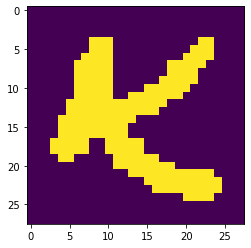

In [281]:
idx = np.random.randint(0, X.shape[0])
print('Y = ', alphabet[y[idx] - 1])
img_crop = get_crop(X.loc[idx])
plt.imshow(img_crop)

In [428]:
%%time

def vect(r):
    dx, dy = np.abs(r[0] - r[2]), np.abs(r[1] - r[3])
    length = np.sqrt((dx ** 2) + (dy ** 2))
    return np.array((
        r[0], r[2],
        length,
        dy / length
    ))

def img_vectors(sample):
    img = np.copy(sample)
    img[img < 128] = 0
    img[img >= 128] = 1
    img = img.reshape(28, 28).T

    img = skeletonize(img)

    lines = probabilistic_hough_line(img, threshold=1, line_length=3, line_gap=2)

    # сортируем сверху вниз, слева направо
    lines.sort(key=lambda x: (x[0][1], x[0][0]))
    l = np.array(lines)
    l = l.reshape(l.shape[0],-1)
    l = np.apply_along_axis(vect, 1, l)
    return l

X_vect = [img_vectors(row) for row in X.values]


CPU times: user 40.9 s, sys: 187 ms, total: 41.1 s
Wall time: 41.3 s


[array([[15.        , 14.        ,  6.08276253,  0.98639392],
        [11.        , 14.        ,  4.24264069,  0.70710678],
        [16.        , 21.        ,  6.40312424,  0.62469505],
        [ 5.        ,  5.        , 10.        ,  1.        ],
        [ 8.        , 14.        ,  6.32455532,  0.31622777],
        [15.        , 16.        ,  5.09901951,  0.98058068],
        [ 5.        ,  6.        ,  8.06225775,  0.99227788]]),
 array([[18.        , 22.        ,  4.        ,  0.        ],
        [10.        , 18.        ,  8.06225775,  0.12403473],
        [ 5.        ,  7.        ,  5.38516481,  0.92847669],
        [11.        , 21.        , 10.        ,  0.        ],
        [ 5.        ,  6.        ,  4.12310563,  0.9701425 ],
        [16.        , 19.        , 11.40175425,  0.96476382],
        [10.        , 15.        ,  5.        ,  0.        ]]),
 array([[11.        , 12.        ,  4.12310563,  0.9701425 ],
        [18.        , 18.        ,  4.        ,  1.        ],
    

In [429]:
X_vect.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# валидационный прогон RF
X_train, X_val, y_train, y_val = train_test_split(no_conv_train, y, test_size=.15, random_state=40)

params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300, 'n_jobs': -1, 'verbose': 49}
clf = RandomForestClassifier(**params)
print(clf.fit(X_train, y_train))

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'{classifier.__name__}:', y_pred.shape, y_pred[:10], acc)

submission = pd.DataFrame({'Id': np.arange(1, X_val_scaled.shape[0] + 1), 'Category': y_pred})
submission.to_csv(f'kaggle_mnist_{classifier.__name__.lower()}_val.csv', index=False)

In [ ]:
# валидационный прогон RF
new_train_df2, dropped = remove_pixels(X)
no_conv_train = new_train_df2.values

X_train, X_val, y_train, y_val = train_test_split(no_conv_train, y, test_size=.2)

params = {
    'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300, 'n_jobs': -1,
    'verbose': 1
}
clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'{classifier.__name__}:', y_pred.shape, y_pred[:10], acc)

submission = pd.DataFrame({'Id': np.arange(1, X_val.shape[0] + 1), 'Category': y_pred})
submission.to_csv(f'kaggle_mnist_{classifier.__name__.lower()}_val.csv', index=False)